# Create Book-level Representation (Validation)

In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
import gensim
from sklearn.manifold import TSNE

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [4]:
np.random.seed(1)
tf.random.set_seed(1)

## Load Data

### Book description

In [5]:
desc_pd = pd.read_csv('data/tosho_processed_clean.csv.bz2', sep='\t', compression='bz2')
desc_pd.shape

(891, 3)

In [6]:
desc_pd.head()

,id,title,description_token
0,3901637,土のコレクション,土 なんて どれ も 同じ じゃ の 茶色 や の 土 しか 見 こと ない よ だれ も ...
1,3901633,わたしの,幼い 子ども たち が これ は 誰 の 物 と 意識 する よう に なる の は 2 歳...
2,3901632,なーらんだ,- ち ゅんちゅんとりさん ぶ ー ぶ ー くるま バラバラ に 散らばっ て い もの が...
3,3901630,つるのおんがえし,昔 ある ところ に 心 の 優しい 若者 が い ある 日 若者 は 罠 に かかっ て ...
4,3901627,ブレーメンのおんがくたい,ある ところ に 年 とっ ロバ が い 年 を とっ て 重い 荷物 を 運べ なっ ので...


### Book category

In [99]:
# Group similar categories
def categorize_book(category):
    new_category = ''
    if category in ['A', 'I']:
        new_category = 'Encyclopedia'
    elif category in ['B', 'J']:
        new_category = 'Literature'
    elif category in ['C']:
        new_category = 'Social Studies'
    elif category in ['D', 'E']:
        new_category = 'Science'
    elif category in ['H']:
        new_category = 'Manga'
    else:
        new_category = 'Picture Book'
    return new_category

In [100]:
category_pd = pd.read_csv('data/tosho_raw.csv.bz2', sep='\t', compression='bz2')
category_pd.drop_duplicates(inplace=True)
category_pd['category'] = category_pd.apply(lambda x: categorize_book(x['category']), axis=1)
category_pd.head(3)

,id,category,title,isbn_raw
0,1000041,Encyclopedia,魚,9784092172043
1,1000042,Encyclopedia,両生類 はちゅう類,9784092172067
2,1000044,Encyclopedia,動物の図鑑,409217005X


In [102]:
text_pd = pd.merge(desc_pd, category_pd, on=['id'])
text_pd.shape

(891, 6)

In [103]:
text_pd = text_pd[['id', 'title_x', 'description_token', 'category']].rename(columns={"title_x": "title"})
text_pd.head()

,id,title,description_token,category
0,3901637,土のコレクション,土 なんて どれ も 同じ じゃ の 茶色 や の 土 しか 見 こと ない よ だれ も ...,Picture Book
1,3901633,わたしの,幼い 子ども たち が これ は 誰 の 物 と 意識 する よう に なる の は 2 歳...,Picture Book
2,3901632,なーらんだ,- ち ゅんちゅんとりさん ぶ ー ぶ ー くるま バラバラ に 散らばっ て い もの が...,Picture Book
3,3901630,つるのおんがえし,昔 ある ところ に 心 の 優しい 若者 が い ある 日 若者 は 罠 に かかっ て ...,Picture Book
4,3901627,ブレーメンのおんがくたい,ある ところ に 年 とっ ロバ が い 年 を とっ て 重い 荷物 を 運べ なっ ので...,Picture Book


In [87]:
text_dict = dict(zip(text_pd.id, text_pd.description_token))

In [88]:
label_dict = {}
for book_id in text_pd.id.unique().tolist():
    label_dict[book_id] = text_dict[book_id]

In [89]:
unique_text_list= [i for i in label_dict.values()]

## Load Book-Representation Model

In [13]:
def load_obj(filename):
    with open(filename, 'rb') as handler:
        return pickle.load(handler)

tokenizer = load_obj('model/tosho_book_model_word_tokenizer.pkl')

In [14]:
book_representation_model = load_model('model/tosho_book_representation.hdf5')

## Get vector representation for each book

In [15]:
def preprocess_text(text):
    MAX_SEQUENCE_LENGTH = 500

    x = tokenizer.texts_to_sequences(text)
    x = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
    
    return x

In [16]:
x_test = preprocess_text(unique_text_list)
x_test.shape

(891, 500)

In [17]:
book_vec = book_representation_model.predict([x_test, x_test, x_test, x_test])
book_vec.shape

(891, 392)

In [18]:
book_vec_list = book_vec.tolist()

## T-SNE

In [19]:
emb = []
labels = []

for i, book_id in enumerate(label_dict):
    emb.append(np.array(book_vec_list[i]))
    labels.append(book_id)

In [90]:
def generate_color_replacements(color_column):
    colors = cm.rainbow(np.linspace(0, 1, text_pd[color_column].nunique()))
    return {key: value for (key, value) in  zip(text_pd[color_column].unique().tolist(), colors)}

In [104]:
color_column = 'category'

patches = []

if color_column:
    cat_replacements = generate_color_replacements(color_column)    
    coloring_list = text_pd[color_column].map(cat_replacements)

    for couple in cat_replacements:
        patch = mpatches.Patch(color=cat_replacements[couple], label=couple)
        patches.append(patch)
else:
    coloring_list = np.zeros(text_pd.shape[0])

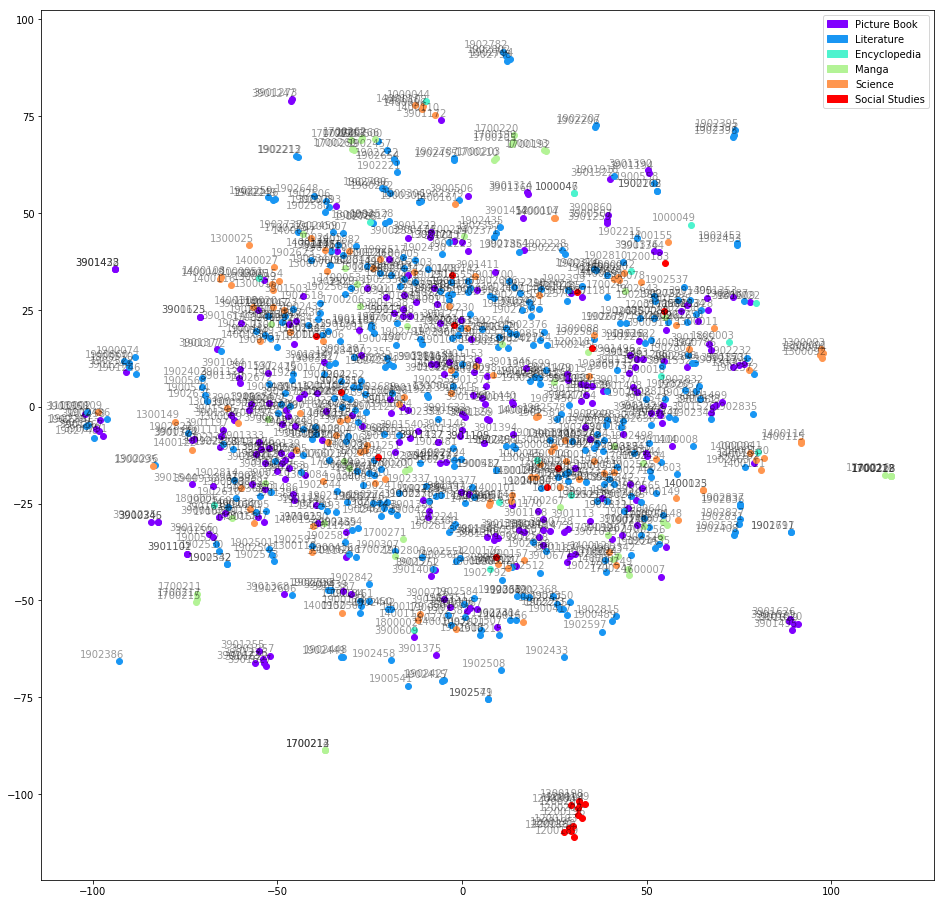

In [105]:
tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=1500, random_state=23)
new_values = tsne_model.fit_transform(emb)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i], c=coloring_list[i])
    plt.legend(handles=patches)
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 alpha=0.4)
plt.show();

In [107]:
perplexity_list = [1, 3, 5, 10, 15, 20, 30]
tsne_perp = [TSNE(n_components=2, random_state=0, init='pca', n_iter=1500, perplexity=perp) for perp in perplexity_list]
tsne_perp_data = [tsne.fit_transform(emb) for tsne in tsne_perp]

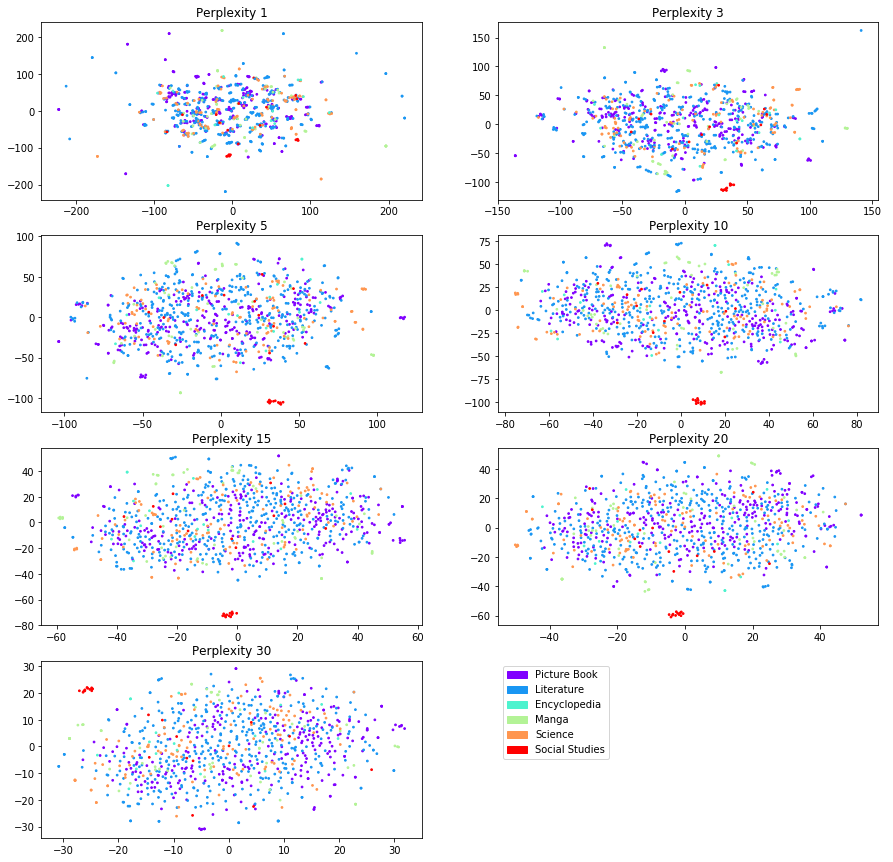

In [108]:
plt.figure(figsize=(15,15))
for i in range(len(perplexity_list)):
    plt.subplot(4,2, i+1)
    plt.title("Perplexity " + str(perplexity_list[i]))
    plt.scatter(tsne_perp_data[i][:,0],tsne_perp_data[i][:,1], c=coloring_list, s=3)
plt.subplot(4,2, i+2)
plt.axis('off')
plt.legend(handles=patches, loc='upper left');

## Save the vectors as Word2Vec format

In [26]:
with open('model/book2vec','a') as f:
    f.write(str(len(label_dict))+' '+str(book_vec.shape[1])+'\n')
    
for i, book_id in enumerate(label_dict):
    with open('model/book2vec','a') as f:
        f.write(str(book_id)+' '+" ".join([str(round(j, 6)) for j in book_vec_list[i]])+ '\n')

## Spot check

In [27]:
b2v = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('model/book2vec', binary=False)

/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [28]:
def spot_check(book_id:int=None):
    if book_id:
        random_book_id = str(book_id)
    else:
        random_book_id = str(pd.Series(list(label_dict.keys())).sample(1).values[0])
    book_desc = label_dict[int(random_book_id)]
    book_w2v_result = b2v.wv.similar_by_word(random_book_id)
    similar_book_id_1 = book_w2v_result[0][0]
    similar_book_desc_1 = label_dict[int(similar_book_id_1)]
    similar_book_id_2 = book_w2v_result[1][0]
    similar_book_desc_2 = label_dict[int(similar_book_id_2)]

    print("Random book ID: {}".format(random_book_id))
    print("Description: {}".format(book_desc))
    print("\n")
    print("1st similar book ID: {}".format(similar_book_id_1))
    print("1st similar book description: {}".format(similar_book_desc_1))
    print("\n")
    print("2nd similar book ID: {}".format(similar_book_id_2))
    print("2nd similar book description: {}".format(similar_book_desc_2))
    print("\n")
    print("word2vec result: {}".format(book_w2v_result))

In [39]:
# Kindergarten
spot_check()

Random book ID: 3901495
Description: むかし あし がら 山 の 山 お くに きん という とても げんき 男 の こ が い きん は うまれ とき から ちか ら もち はじめて のめ いさ くえ ほん シリーズ 幼児 向け 厚紙 絵本


1st similar book ID: 3901619
1st similar book description: おじいさん が おむすび を 食べよ と する と おむすび は ころころ ころころ ころがっ て あな の へ す とんと おち て しまい はじめて のめ いさ くえ ほん シリーズ 幼児 向け 厚紙 絵本


2nd similar book ID: 3901620
2nd similar book description: ある ひ かあさん ぶた が いい みんな も 大きく なっ から ぶん で 家 を たて なさい はじめて のめ いさ くえ ほん シリーズ 幼児 向け 厚紙 絵本


word2vec result: [('3901619', 0.764175295829773), ('3901620', 0.7386701703071594), ('3901621', 0.7187644243240356), ('3901626', 0.7157090306282043), ('1902201', 0.5734683871269226), ('3901543', 0.5620286464691162), ('1902228', 0.5457043647766113), ('1901918', 0.522849977016449), ('1902533', 0.5071357488632202), ('3901185', 0.5059606432914734)]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [73]:
# dinosaurs, animals
spot_check()

Random book ID: 1400096
Description: ドキドキ ワクワク まんが で とびこむ 科学 の 界 きょう りゅう 大好き 少年 の ヒロキ は 姉 の ユミ と 国立 科学 博物館 で アロサウルス や ブロントサウルス の 全身 骨格 を 見 て びっくり ちょっと と ぼけ 古 生物 学者 古 博士 とともに 歴史 探偵 に 変身 し て 大昔 へ の 旅 に 出 さあ みなさん も いっしょ に たのしい 1 億 5000 年 前 の 界 へ でかけ か 小学校 高学年 向 きょう りゅう 大好き 少年 の ヒロキ は 姉 の ユミ と 国立 科学 博物館 で アロサウルス や プロントサウルス の 全身 骨格 を 見 て びっくり 古 生物 学者 の 古 博士 と共に 歴史 探偵 に 変身 し て 1 億 5 千 年 前 の 旅 に 出 て 恐竜 の 謎 に 迫り


1st similar book ID: 1400102
1st similar book description: ペンギン アザラシ アホウドリ 人間 の 計り 知れ 界 を 生きる 動物 たち その 体 に 記録 機器 を 取り付ける 手法 バイオ ロギング を 用い 驚く メカニズム に 迫る 近所 の 鳥 へ の 眼差し も 新 目次 第 章 渡る ---- ペンギン が 解き明かし 回遊 の 謎 動物 は どこ に 何 し に 行く の ミズナギドリ の 終わら 夏 アホウドリ の 46 日間 地球 周 クロマグロ の 太平洋 横断 ホホジロザメ の インド洋 横断 ザトウクジラ の 半球 内 季節 移動 アルゴス ---- 最も メジャー 動物 追跡 システム 南極 の アデリーペンギン 南極 袋 浦 で の 調査 第 章 泳ぐ ---- 遊泳 の 技巧 は サメ に 習う マグロ は 時速 100 キロ は 泳が 薄気味悪い ニシオンデンザメ サメ よ どうして そんなに のろい の か ペンギン アザラシ クジラ も まとめ て 競 速い と いっ て も 知れ て いる ペンギン の 法則 マンボウ は なぜ 浮き袋 が ない の に 浮く マンボウ の 意外 泳ぎ の メカニズム 第 章 測る ---- 先駆 者 が 磨い 計測 の 技 バ

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [38]:
# Same series (fantasy, historical fiction)
spot_check()

Random book ID: 1902255
Description: ジャック と アニー の 兄妹 が 魔法 の ツリー ハウス に のっ て 界 の すぐれ 本 を さがし に 冒険 の 旅 に 出 今回 は 古代 ローマ帝国 の 都市 ポンペイ と 秦 の 都 西安 へ カバー 袖 に きせ か え 人形 つき 著者 略歴 著者 紹介 情報 より オズボーン メアリー ポープノースカロライナ 大学 で 演劇 と 比較 宗教 学 を 学ん 後 界 各地 を 旅 し 児童 雑誌 の 編集 者 など を 経 て 児童 文学 作家 と なる 以来 神話 や 伝承 物語 を 心 に 80 作 以 を 発表 し 数 の 賞 に 輝い また アメリカ 作家 協会 の 委員 長 を 2 期 にわたって 務め て いる コネティカット 州 在住 食 野 雅子 国際基督教大学 卒業 後 サイ マル 出版 会 を 経 て 翻訳 家 に 4 女 の 母 本 データ は この 書籍 が 刊行 さ れ 当時 に 掲載 さ れ て い もの


1st similar book ID: 1902253
1st similar book description: ジャック と アニー の 兄妹 が 魔法 の ツリー ハウス に って 海底 に 冒険 の 旅 へ イルカ の 兄弟 や お化け ダコ 潜水 艇 から の 脱出 など 件 が 続出 2 人 は どう なる 他 ゴースト タウン の 亡霊 を 収録 カバー 袖 に きせ か え 人形 つき 著者 略歴 著者 紹介 情報 より オズボーン メアリー ポープノースカロライナ 大学 で 演劇 と 比較 宗教 学 を 学ん 後 界 各地 を 旅 し 児童 雑誌 の 編集 者 など を 経 て 児童 小説 家 と なる 以来 神話 や 伝承 物語 を 心 に 40 作 以 を 発表 し 数 の 賞 に 輝い また アメリカ 作家 協会 の 委員 長 を 2 期 にわたって 務め て いる ニューヨーク 市 在住 食 野 雅子 国際基督教大学 卒業 後 サイ マル 出版 会 を 経 て 翻訳 家 に 本 データ は この 書籍 が 刊行 さ れ 当時 に 掲載 さ れ て い もの


2nd similar book ID: 1902257

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [83]:
# Fantasy
spot_check()

Random book ID: 1902427
Description: 読み だし やめ られ 国 の 大 伝奇 ロマン 軍師 に 姜 子 牙 きょう し が 太公望 を 得 て 紂 ち ゅう 王 討伐 の 軍 を 興し 周 の 文 王 は 征途 なかば に し て を 去っ 子 姫 発 き はつ が 後 を 嗣ぎ 武 王 を 名 方 都 朝 歌 ちょう か では 千 年 の 狐狸 精 妲己 妲妃 欺弄 さ れ て 紂王 が 自堕落 日 を 過ごし て い 諸侯 は 相次い で 旗揚げ 武 王 を 盟 と 仰い で 会 盟 の 地 孟 津 もう しん へ と 兵馬 を 進める 全 3 巻 国 代 奇書 を 超える 大 伝奇 ロマン 軍師 に 姜 子 牙 太公望 を 得 て 紂王討 伐 の 軍 を 興し 周 の 文 王 は 征途 なかば に し て を 去っ 子 姫 発 が 跡 を 嗣ぎ 武 王 を 名 方 都 朝 歌 で は 千 年 の 狐狸 精 妲己 妲妃 に 欺弄 さ れ て 紂王 が 自堕落 日 を 過し て い しだいに 民 の 間 に 怨嗟 の 声 が つのり 諸侯 は 相次い で 旗揚げ 武 王 を 盟 と 仰い で 会 盟 の 地 孟 津 へ と 兵馬 を 進める 全 3 巻


1st similar book ID: 1902415
1st similar book description: 読み だし やめ られ 国 の 大 伝奇 ロマン 商 から 周 へ 国 で は いま 易姓革命 が 始まろ と し て いる 名君 紂 ち ゅう 王 は 妖妃妲 己 を 迎え て 以来 まったく の 昏君 フンチュン バカ 皇帝 と 化し 妲己 彼女 は じつは 千 年 の を 経 女 狐 の 化身 の 軍師 太公望 姜 子 牙 を 擁する 西 岐軍 と 商 軍 の 大 殺戮 戦 妖術 が 切り結び 秘密 兵器 が 飛び交う 奇書 全 3 巻 商 から 周 へ 国 で は いま 易姓革命 が 始まろ と し て いる 名君 紂王 は 妖妃妲 己 を 迎え て 以来 まったく の 昏君 バカ 皇帝 と 化し 妲己 彼女 は じつは 千 年 の を 経 女 狐 の 化身 の 軍師 太公望 姜 子 牙 を 擁する 西 岐軍 と 商 軍 の 大 殺戮 戦 妖術 玄 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [45]:
# Encyclopedia, educational
spot_check()

Random book ID: 1400107
Description: 学研 の 図鑑 は 子ども の 目 が きらきら と 輝く 図鑑 ニュー ワイド 学研 の 図鑑 は 写真 に こだわっ 本格 図鑑 の 決定 版 写真 で 本物 を リアル に 伝え 最新 の 情報 を わかり やすく 伝え すべて の 漢字 に 読み が なつき で 幼児 から 知識 や 驚き を 伝え 自由 研究 の テーマ が いっぱい 自由 研究 を 実験 観察 工作 に 分け て テーマ を 紹介 し て ある ので 自分 に 合っ 自由 研究 が 選べ 写真 で わかり やすい どの 実験 も やり方 まとめ 方 を 大きな 写真 で わかり やすく 紹介 し て いる ので 自由 研究 が 簡単 に 出来 読者 の 声 より 学校 の 自由 研究 めんどく せ ー とか 思っ て い が 図鑑 を 読ん で み て それ が なくなり 反対 に 2 3 こ くらい 実験 が やり なり 小 6 女児 観察 自由 研究 と 実験 工作 自由 研究 の の ブロック に 分かれ て い 自由 研究 の ヒント や 研究 の 進め方 まとめ 方 など を 写真 や イラスト で くわしく しょうかい し て い


1st similar book ID: 1400014
1st similar book description: 学研 の 図鑑 は 子ども の 目 が きらきら と 輝く 図鑑 ニュー ワイド 学研 の 図鑑 は 写真 に こだわっ 本格 図鑑 の 決定 版 写真 で 本物 を リアル に 伝え 最新 の 情報 を わかり やすく 伝え すべて の 漢字 に 読み が なつき で 幼児 から 知識 や 驚き を 伝え 自由 研究 の テーマ が いっぱい 自由 研究 を 実験 観察 工作 に 分け て テーマ を 紹介 し て ある ので 自分 に 合っ 自由 研究 が 選べ 写真 で わかり やすい どの 実験 も やり方 まとめ 方 を 大きな 写真 で わかり やすく 紹介 し て いる ので 自由 研究 が 簡単 に 出来 読者 の 声 より 学校 の 自由 研究 めんどく せ ー とか 思っ て い が 図鑑 を 読ん で み て それ が なくなり 反対

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [66]:
# fairy tale
spot_check()

Random book ID: 3900507
Description: 昔 ある ところ に 子ども の い じい さま と ば あ さま が あっ と ある 日 じい さま が 山 へ しばかり に 行く と 羽 の すずめ が ち ゅん ち ゅん と 鳴き ながら そば へ やってき て ねえ 70 年 講談社 刊 を 再 構成


1st similar book ID: 3901259
1st similar book description: 昔 ある ところ に ほっ ぺたにこぶをつけたじいさまが ふたり い て ねえ 会う たん びにこぶをなでながら この こ ぶ みっともない のう そう 言っ て は 嘆い て おっ 71 年 講談社 刊 を 再 構成


2nd similar book ID: 3900860
2nd similar book description: わる さ を する たぬき に 苦しめ られる じい さま ば あ さま まで 殺さ れ 嘆き 悲しむ じい さま の ため に うさぎ が 仇 を とろ と たぬき が 背負っ かや に 火 を つけ て 70 年 講談社 刊 を 再 構成


word2vec result: [('3901259', 0.7960047721862793), ('3900860', 0.6375426650047302), ('3901162', 0.5405400991439819), ('3901378', 0.49566417932510376), ('1900416', 0.4938107430934906), ('3901540', 0.49177730083465576), ('1902516', 0.48995542526245117), ('3901615', 0.48951900005340576), ('1901181', 0.48890674114227295), ('1400026', 0.487460196018219)]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [33]:
# Police investigation
spot_check()

Random book ID: 1902436
Description: 警視庁 刑 総務 課 に 勤める 大友 鉄 は かつて 所属 し 劇団 の 記念 公演 に 招待 さ れる だが 宰 の 笹倉 が 舞台 で 絶命 それ は まさに 演 さ れ て い シナリオ 通り の 展開 大友 は 過去 と 向き合い つつ 昔 の 仲間 たち を 容疑 者 として 取り調べる こと に なる アナザーフェイス シリーズ 第 弾 著者 略歴 著者 紹介 情報 より 堂 場 瞬 1963 年 生まれ 茨城 県 出身 青山学院大学 国際 政治 経済学部 卒業 新聞 社 勤務 の かたわら 小説 の 執筆 を はじめる 2000 年 に 8 年 で 第 13 回 小説 すばる 新人 賞 受賞 本 データ は この 書籍 が 刊行 さ れ 当時 に 掲載 さ れ て い もの


1st similar book ID: 1902432
1st similar book description: ベストセラー 刑 鳴沢 シリーズ の 著者 が 新た 刑 を 生み出し 雨 の 横浜 猟犬 と 呼ば れる 男 神奈川 県警 捜査 課 真崎 薫 の 孤独 戦い が 始まる 連続 殺人 犯 青 猛 郎 を 追い詰め 真崎 が コンビ を 組ん 赤 澤 奈津 を かばっ 瞬 の 隙 を つかれ 深手 を 負い 青 の 逃走 を 許し て しまう 手がかり の ない まま カ月 が 経ち 退院 し 真崎 は 捜査 に 復帰 を 願う も 担当 から は はずさ れ て おり 休暇 を 命じ られ て しまう ば と 独自 に 捜査 を 開始 し 真崎 が 青 が 次に 狙っ の は 意外 人物 真崎 赤 澤 青 人 の それぞれ の 過去 が 明らか に なる につれ 複雑 に 絡み合っ 件 の 真相 も 明らか に なっ て いく 容赦 なく つきつけ られる 過去 を 過去 として 受け入れ 魂 の やすらぎ を 得 られる 日 は 真崎 に 訪れる の か 警察 小説 の 名手 が 描く 緊迫 の 長編 サスペンス シリーズ 第 弾 雨 の 横浜 猟犬 と 呼ば れる 男 神奈川 県警 捜査 課 真崎 薫 の 孤独 戦い が 始まる 連続 殺人 犯 青 猛 郎 を 追い詰め 真崎 が 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [97]:
# books with bears
spot_check()

Random book ID: 3901322
Description: 森 の お くに 1 匹 の くま が おり 木の葉 が ちり がん が 南 へ とん で いく ころ に なる と くま は 眠く なり くま は ほら あな に むかい 冬眠 に はいり その あいだ に 森 に 人間 が たくさん やってき て 木 を 切り倒し 大きな 工場 を 建て の 冬眠 から さめ くま が あまり の 変わり よう に 工場 を ぽかんと み て いる と 工場 の 職長 が やってき て おい おまえ とっとと 仕 につけ とど なり くま は 腰 を ぬかす ほど 驚い て ぼく は くま ん けど と いい が ききいれ られ うすぎたない ひ げ も そら なまけもの に さ れ て しまい 人間 の 身勝手 さ と 自然 の まま の くま で い くま を シュタイナー と ミュラー の コンビ が ユーモア と 風刺 を こめ て 見 に 描き出し て い


1st similar book ID: 1901918
1st similar book description: 森 のせん や さん あな ぐま モン タン の ところ に むささび や うさぎ や くま が 空 から おち て き ミトン を ひろっ て もっ て き それ は 空 に すむ 風の子 が 星 を みがい て い て うっかり おとし もの だい に し て くれる いい よ あげる 風の子 に いわ れ て みんな は 大 よろこび 読ん で あげる 幼稚園 から 自分 で 読む 小学校 年生 向き 風 の つよい 朝 空 から ミトン が おち て き いったい 誰 の もの その 夜 せ の モン タン の ところ へ 風の子 が やってき 風の子 が その ミトン で 星 を みがく 練習 を し て い ん だって あな ぐま モン タン の お はなし 第 3 弾


2nd similar book ID: 3901194
2nd similar book description: くま くん から 絵 を もらっ お礼 に おばあさん ぐまは くま くん に キス を とどけ て もらい キス は 動物 たち に 次つぎ に 受け がれ やっと くま 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [101]:
# manga series
spot_check()

Random book ID: 1700259
Description: レベル ファイブ 最新 ゲーム を 最速 マンガ 化 イナズマイレブン ダンボール 戦機 に 続く コロコロコミック レベルファイブプロジェクト 第 3 弾 ごくごく 普通 の 小学 5 年生 天野 ケータ と 妖怪 執 ウィスパー が 織りなす ドタバタ 妖怪 ギャグ コメディ の 第 1 巻 ある 日 森 の で ヘン テコ 妖怪 ウィスパー から もらっ 思議 アイテム 妖怪 ウォッチ を 手 に し 人 公 ケータ は それ 以降 見え はず の 妖怪 が 見える よう に なる 悩ん で いる 妖怪 イタズラ する 妖怪 様 妖怪 達 の 抱える 問題 を 解決 し 彼ら と 友達 に 読め ば 必ず 笑っ て ホッコリ 妖怪 マンガ の 新 定番 が ここ に 誕生 編集 担当 から の おすすめ 情報 7 月 に 発売 を 控える 最新 ゲーム に 先駆け 妖怪 ウォッチ の 界 を 完全 再現 足 先 に 妖怪 ワールド の 魅力 に ハマっ て ください


1st similar book ID: 1700260
1st similar book description: 大人気 ゲーム を 完全 マンガ 化 コロコロ コミック 本誌 でも 大人気 イナズマイレブン ダンボール 戦機 に 続く コロコロコミック レベルファイブプロジェクト 第 3 弾 ごくごく 普通 の 小学 5 年生 天野 ケータ と 妖怪 執 ウィスパー 地 縛 霊 妖怪 の ジバニャン が 織りなす ドタバタ 妖怪 ギャグ コメディ の 第 2 巻 ある 日 森 の で ヘン テコ 妖怪 ウィスパー から もらっ 思議 アイテム 妖怪 ウォッチ を 手 に し 人 公 ケータ は それ 以降 見え はず の 妖怪 が 見える よう に なる 悩ん で いる 妖怪 イタズラ する 妖怪 様 妖怪 達 の 抱える 問題 を 解決 し 彼ら と 友達 に 第 2 巻 は 大人気 妖怪 の ジバニャン が あんな 姿 や こんな 姿 に ひたすら 笑える 妖怪 ギャグ マンガ の 新 定番 編集 担当 から の おすすめ 情報 1 月 8 日 より 始まる アニメ に 先駆け 第 2 巻 が 発売 アニメ を

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [102]:
# history
spot_check()

Random book ID: 1200190
Description: 歴史 学習 の 最先端 は 東大 流 まったく 新しい 学習 まんが の 進化 形 第 1 巻 東大 の 入試 問題 や 近年 の 歴史 教育 の 現場 で 今 最も 重視 さ れ て いる の は 歴史 の 大きな 流れ を つかむ こと 歴史 の 流れ が おもしろい ほど よく 分かる 最強 学習 まんが が 誕生 第 1 巻 は 旧 石器 縄文 弥生 古墳 時代 3 数 千 年 前 マンモス や ナウ マン 象 を 追いかけ て 大陸 から 陸続き 日本 列島 に 人類 が 移動 し て き 縄文 時代 の 末期 稲 の 栽培 が 始まる と 貧富 の 差 が 生まれ 弥生 時代 に は 小さな 国 同士 の 戦 も 起こり やがて 邪馬台国 の 卑弥呼 の よう に 国 に 使者 を 送っ て 王 の 地位 を 認め て もらう 者 が 出 て き 本 巻 で は 旧石器時代 から 大和 政権 の 成立 まで の 日本 列島 の 歴史 を 見 て いき


1st similar book ID: 1200195
1st similar book description: 歴史 学習 の 最先端 は 東大 流 まったく 新しい 学習 まんが の 進化 形 第 7 巻 東大 の 入試 問題 や 近年 の 歴史 教育 の 現場 で 今 最も 重視 さ れ て いる の は 歴史 の 大きな 流れ を つかむ こと 歴史 の 流れ が おもしろい ほど よく 分かる 最強 学習 まんが が 誕生 第 7 巻 は 室町 時代 期 戦国 時代 室町 幕府 は 守護 の 勢力 を おさえよ と し が 反発 を 受け しだい に 弱体 化 し 守護 と 将軍家 の 跡目 いに 端 を 発し 応仁 の が 起こる と 全国 の 武士 は 東 軍 と 西 軍 に 分かれ て い 京都 は 荒廃 し 地方 で は 剋 の 動き の なか 守護 が 没落 し て 守護 代 や 国人 が 権力 を にぎり 戦国 時代 へ と 入っ て いき 本 巻 で は 室町 幕府 が 衰退 し 戦国 大名 が 誕生 し て 戦い を くり広げる 時代 を 見 て いき


2nd similar book ID: 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
